# Предсказываем спрос на аренду велосипедов

In [29]:
import numpy as np
import pandas as pd
import pydot as p
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics, pipeline, preprocessing
from sklearn.ensemble import RandomForestRegressor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\ksush\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


https://www.kaggle.com/c/bike-sharing-demand

Системы совместного использования велосипедов - это средство аренды велосипедов, где процесс получения членства, аренды и возврата велосипедов автоматизирован через сеть киосков по всему городу. Используя эти системы, люди могут арендовать велосипед из одного места и возвращать его в другое место по мере необходимости. В настоящее время в мире действует более 500 программ обмена велосипедами.

Данные, сгенерированные этими системами, делают их привлекательными для исследователей, поскольку продолжительность поездки, место отправления, место прибытия и истекшее время явно записаны. Поэтому системы совместного использования велосипедов функционируют как сенсорная сеть, которую можно использовать для изучения мобильности в городе. В этом конкурсе участников просят объединить исторические модели использования с данными о погоде, чтобы прогнозировать спрос на аренду велосипедов в рамках программы Capital Bikeshare в Вашингтоне, округ Колумбия.

Тренировочный набор состоит из первых 19 дней каждого месяца, а тестовый набор - с 20-го по конец месяца.


# Задача 

спрогнозировать общее количество велосипедов, арендованных в течение каждого часа, покрываемого тестовым набором, используя только информацию, доступную до периода проката.

# Описание датасета:

Параметры:

datetime - почасовая дата + отметка времени

season - 1 = весна, 2 = лето, 3 = осень, 4 = зима

holiday - считается ли день праздником

workingday - будь то выходной или праздничный день

weather - 1: Ясно, Облачно, Небольшая Облачность

2: Туман + Облачно, Туман + Разбитые облака, Туман + Немного облаков, Туман

3: легкий снег, легкий дождь + гроза + рассеянные облака, легкий дождь + рассеянные облака

4: сильный дождь + ледяные поддоны + гроза + туман, снег + туман

temp - температура в градусах Цельсия

atemp - "ощущается как" температура в градусах Цельсия

humidity - относительная влажность

windspeed - скорость ветра

casual - количество инициированных прокатов незарегистрированных пользователей

registered - количество зарегистрированных арендованных пользователей

count - количество всех арендных плат

In [2]:
#импорт датасета
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
submission = pd.read_csv('sampleSubmission.csv')

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


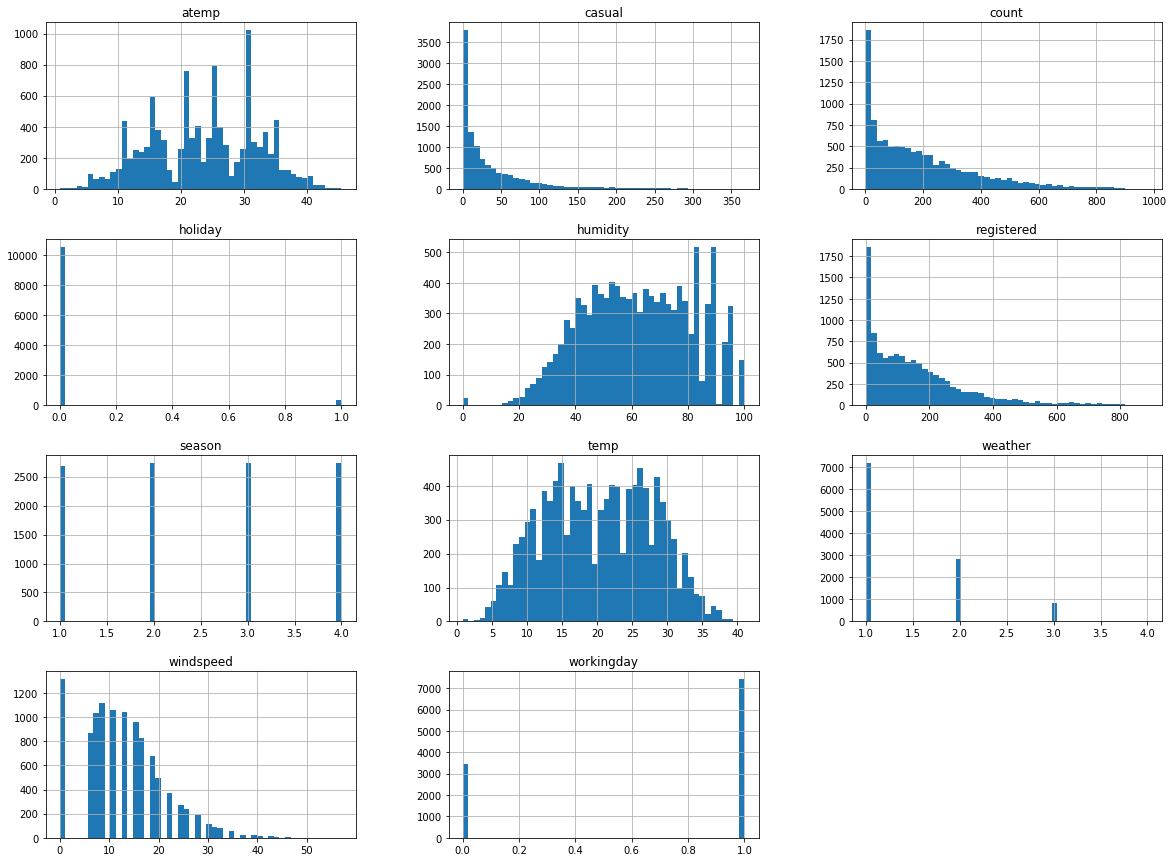

In [9]:
# визуализация данных
train.hist(bins=50, figsize=(20,15))
plt.show()

C:\Users\ksush\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


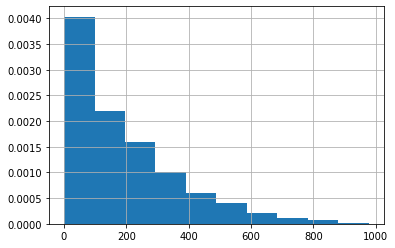

In [33]:
train['count'].hist(bins=10, normed=1)

PEARSON CORRELATION
              season   holiday  workingday   weather      temp     atemp  \
season      1.000000  0.029368   -0.008126  0.008879  0.258689  0.264744   
holiday     0.029368  1.000000   -0.250491 -0.007074  0.000295 -0.005215   
workingday -0.008126 -0.250491    1.000000  0.033772  0.029966  0.024660   
weather     0.008879 -0.007074    0.033772  1.000000 -0.055035 -0.055376   
temp        0.258689  0.000295    0.029966 -0.055035  1.000000  0.984948   
atemp       0.264744 -0.005215    0.024660 -0.055376  0.984948  1.000000   
humidity    0.190610  0.001929   -0.010880  0.406244 -0.064949 -0.043536   
windspeed  -0.147121  0.008409    0.013373  0.007261 -0.017852 -0.057473   
casual      0.096758  0.043799   -0.319111 -0.135918  0.467097  0.462067   
registered  0.164011 -0.020956    0.119460 -0.109340  0.318571  0.314635   
count       0.163439 -0.005393    0.011594 -0.128655  0.394454  0.389784   
month       0.971524  0.001731   -0.003394  0.012144  0.257589  0.26

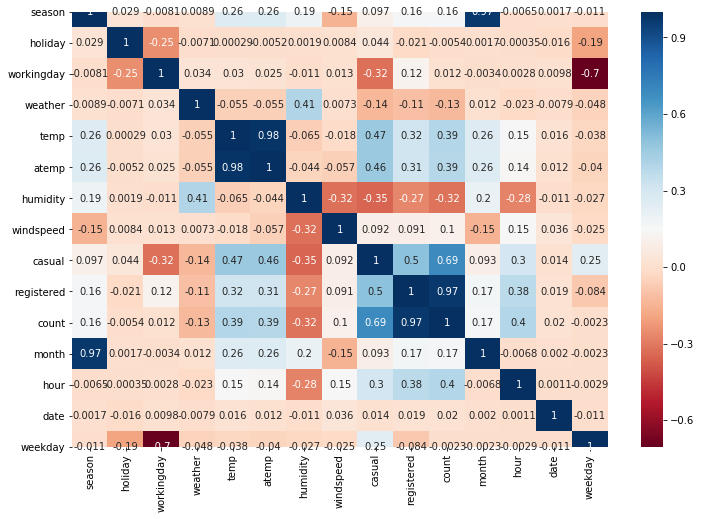

In [35]:
#корреляция между атрибутами
print("PEARSON CORRELATION")
print(train.corr(method="pearson"))
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="pearson"), annot =True, cmap='RdBu')
plt.show()

SPEARMAN CORRELATION
              season   holiday  workingday   weather      temp     atemp  \
season      1.000000  0.029419   -0.008148  0.010918  0.248172  0.246713   
holiday     0.029419  1.000000   -0.250491 -0.002176  0.001751 -0.003464   
workingday -0.008148 -0.250491    1.000000  0.028863  0.031065  0.027566   
weather     0.010918 -0.002176    0.028863  1.000000 -0.057912 -0.061933   
temp        0.248172  0.001751    0.031065 -0.057912  1.000000  0.987128   
atemp       0.246713 -0.003464    0.027566 -0.061933  0.987128  1.000000   
humidity    0.186981  0.000186   -0.010048  0.399492 -0.046854 -0.042028   
windspeed  -0.131726  0.009087    0.017455 -0.006648 -0.005535 -0.036350   
casual      0.164379  0.027815   -0.200019 -0.139055  0.573034  0.571588   
registered  0.177400 -0.011585    0.063074 -0.103204  0.352174  0.350577   
count       0.176376 -0.001634   -0.000386 -0.114133  0.407989  0.406562   
month       0.971621  0.001916   -0.003481  0.015330  0.247465  0.2

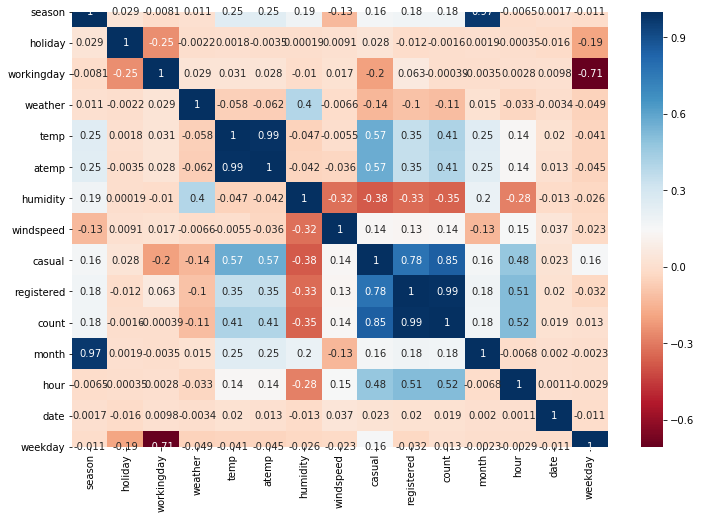

In [38]:
print("SPEARMAN CORRELATION")
print(train.corr(method="spearman")) 
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="spearman"), annot =True, cmap='RdBu')
plt.show()

KENDALL CORRELATION
              season   holiday  workingday   weather      temp     atemp  \
season      1.000000  0.026856   -0.007438  0.009707  0.193346  0.190105   
holiday     0.026856  1.000000   -0.250491 -0.002115  0.001451 -0.002868   
workingday -0.007438 -0.250491    1.000000  0.028050  0.025743  0.022817   
weather     0.009707 -0.002115    0.028050  1.000000 -0.046364 -0.049588   
temp        0.193346  0.001451    0.025743 -0.046364  1.000000  0.955043   
atemp       0.190105 -0.002868    0.022817 -0.049588  0.955043  1.000000   
humidity    0.139663  0.000153   -0.008274  0.324066 -0.032077 -0.027299   
windspeed  -0.103203  0.007712    0.014814 -0.005357 -0.003516 -0.025077   
casual      0.120411  0.022976   -0.165217 -0.112385  0.413319  0.410275   
registered  0.132095 -0.009478    0.051604 -0.082321  0.240250  0.237979   
count       0.130245 -0.001336   -0.000315 -0.091179  0.280627  0.278226   
month       0.904529  0.001628   -0.002958  0.012570  0.176514  0.17

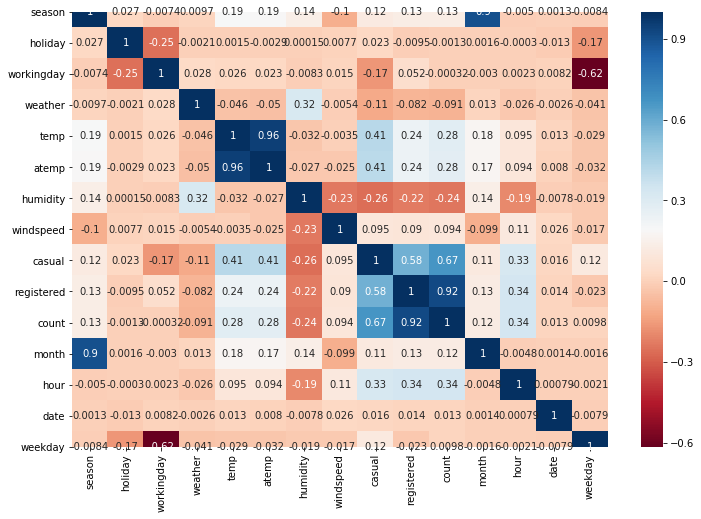

In [39]:

print("KENDALL CORRELATION")

print(train.corr(method="kendall"))
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="kendall"), annot =True, cmap='RdBu')
plt.show()

TypeError: ufunc multiply cannot use operands with types dtype('<M8[ns]') and dtype('float64')

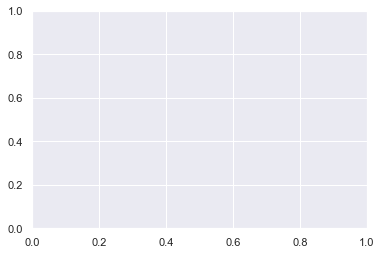

In [44]:
import warnings
import random
import os
sns.set(color_codes=True)
colors = ["y", "b", "g", "r"]

cols = list(train.columns.values)
warnings.filterwarnings('ignore')

for i, col in enumerate(cols):
    sns.distplot(train[col], color=random.choice(colors))
    plt.show()

In [10]:
# делим datetime на параметры
train.datetime = train.datetime.apply(pd.to_datetime)
train['month'] = train.datetime.apply(lambda x : x.month)
train['hour'] = train.datetime.apply(lambda x : x.hour)
train['date'] = train.datetime.apply(lambda x : x.day)
train['weekday'] = train.datetime.apply(lambda x : x.weekday())
train.head(400)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,date,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,1,0,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,1,2,1,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,1,3,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,1,4,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2011-01-17 23:00:00,1,1,0,3,6.56,6.820,86,19.0012,1,3,4,1,23,17,0
396,2011-01-18 12:00:00,1,0,1,2,8.20,9.090,86,22.0028,0,3,3,1,12,18,1
397,2011-01-18 13:00:00,1,0,1,2,8.20,9.850,86,15.0013,0,22,22,1,13,18,1
398,2011-01-18 14:00:00,1,0,1,2,9.02,11.365,80,11.0014,2,26,28,1,14,18,1


Text(0, 0.5, 'registered')

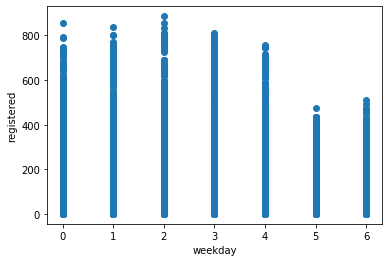

In [11]:
# статистика по дням недели для зарегестрированных пользователей
plt.scatter(train['weekday'], train['registered'])
plt.xlabel('weekday')
plt.ylabel('registered')

Text(0, 0.5, 'casual')

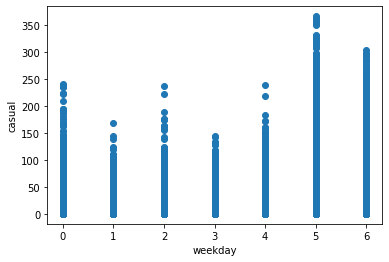

In [12]:
# статистика по дням недели для не зарегестрированных пользователей
plt.scatter(train['weekday'], train['casual'])
plt.xlabel('weekday')
plt.ylabel('casual')

Text(0, 0.5, 'count')

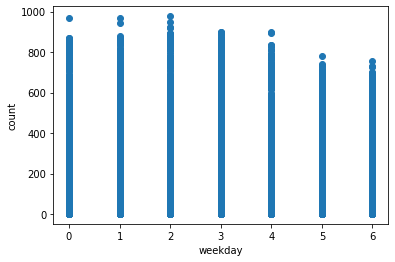

In [13]:
# статистика по дням недели для не зарегестрированных пользователей
plt.scatter(train['weekday'], train['count'])
plt.xlabel('weekday')
plt.ylabel('count')

Text(0, 0.5, 'registered')

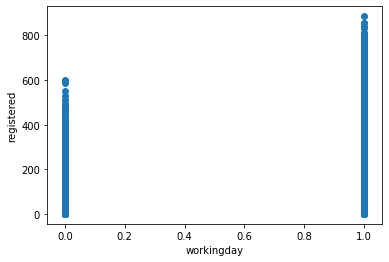

In [14]:
# статистика по рабочим/выходным дням недели для зарегестрированных пользователей
plt.scatter(train['workingday'], train['registered'])
plt.xlabel('workingday')
plt.ylabel('registered')

Text(0, 0.5, 'casual')

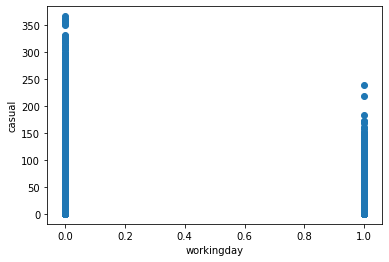

In [15]:
# статистика по рабочим/выходным дням недели для не зарегестрированных пользователей
plt.scatter(train['workingday'], train['casual'])
plt.xlabel('workingday')
plt.ylabel('casual')

Text(0, 0.5, 'count')

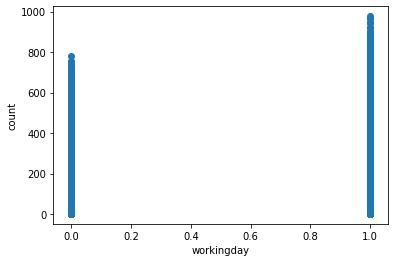

In [16]:
plt.scatter(train['workingday'], train['count'])
plt.xlabel('workingday')
plt.ylabel('count')

Text(0, 0.5, 'casual')

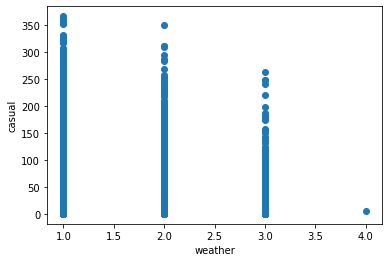

In [17]:
plt.scatter(train['weather'], train['casual'])
plt.xlabel('weather')
plt.ylabel('casual')

Text(0, 0.5, 'registered')

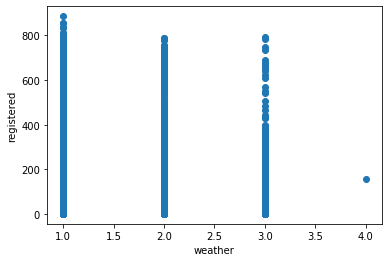

In [18]:
plt.scatter(train['weather'], train['registered'])
plt.xlabel('weather')
plt.ylabel('registered')

Отметим что данные являются ли пользователи зарегистрированными или нет не влияютна тагрет переменную, поэтому удалим столбцы registered и casual

In [19]:
X = train.drop(['datetime','count', 'casual', 'registered'], axis = 1)
Y = train['count'].values

In [22]:
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.25, random_state=42)

In [25]:
binary_columns = ['holiday', 'workingday']
binary_indices = np.array([(column in binary_columns) for column in X.columns], dtype = bool)

categorical_columns = ['season', 'weather', 'month', 'date', 'weekday']
categorical_indieces = np.array([(column in  categorical_columns) for column in X.columns], dtype = bool)

numeric_columns = ['temp', 'atepm', 'humidity', 'windspeed', 'hour']
numeric_indices = np.array([(column in numeric_columns) for column in X.columns], dtype = bool)

regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 200)
estimator = pipeline.Pipeline(steps = [
    ('feature_processing0', pipeline.FeatureUnion(transformer_list = [
        ('binary_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_indices], validate = True)),
        
        ('numeric_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean = 0.))
                ])),
        
        ('categorical_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_indieces])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
                ])),
    ])),
    ('model_fitting', regressor)
    ]
)

In [26]:
estimator.fit(np.array(train_data), train_labels)

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('feature_processing0',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x000001ECA44C4438>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=True)),
                                                ('numeric_processing',
                        

In [27]:
metrics.mean_absolute_error(test_labels, estimator.predict(np.array(test_data)))

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


42.85296581891898

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Text(0.5, 1.0, 'Results')

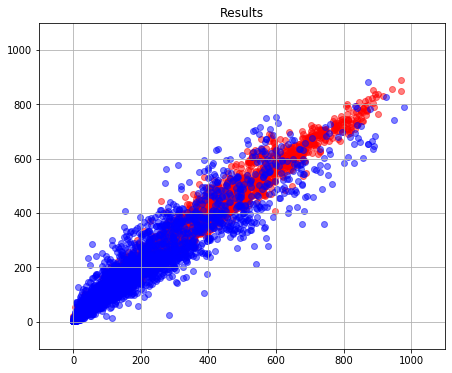

In [30]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1, 2, 2)
pylab.grid(True)
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.scatter(train_labels, estimator.predict(np.array(train_data)), alpha = 0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(np.array(test_data)), alpha = 0.5, color = 'blue')
pylab.title("Results")

In [31]:
print(test_labels[:10])
(estimator.predict(np.array(test_data)))[:10]

[127  13 163 233 222 166 144 376 601  53]


C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([180.36015649,  49.86      , 162.256     , 166.76361813,
       182.25      , 159.7946526 , 165.44149298, 390.28452367,
       629.88892023,  80.70729398])

In [32]:
result = pd.read_csv('test.csv', header = 0, sep = ',')
result.datetime = result.datetime.apply(pd.to_datetime)
result['month'] = result.datetime.apply(lambda x : x.month)
result['hour'] = result.datetime.apply(lambda x : x.hour)
result['date'] = result.datetime.apply(lambda x : x.day)
result['weekday'] = result.datetime.apply(lambda x : x.weekday())
output = result
output = output.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'date', 'weekday'], axis = 1)
result = result.drop(['datetime'], axis = 1)


predictions = estimator.predict(np.array(result))
output = pd.read_csv('sampleSubmission.csv', header = 0, sep = ',')
output['count'] = predictions
output.to_csv('sampleSubmission.csv', index=False)
output.head()

C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\ksush\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


,datetime,count
0,2011-01-20 00:00:00,15.237733
1,2011-01-20 01:00:00,4.015000
2,2011-01-20 02:00:00,3.096720
3,2011-01-20 03:00:00,3.435745
4,2011-01-20 04:00:00,2.878129
